In [8]:
from arftools import *
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import os.path


def mse(datax,datay,w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    n, d = datax.shape
    loss = np.dot((np.dot(datax,w.T)-datay),(np.dot(datax,w.T)-datay).T)
    return loss/n

def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    weights = w
    x,y = weights.shape
    n, d = datax.shape
    #import ipdb; ipdb.set_trace()
    grad = 2*np.dot(datax.T,(np.dot(datax,weights.T)-datay))
    avg_grad = grad.reshape(x,y)/n
    return avg_grad

def hinge(datax,datay,w):
    """ retourn la moyenne de l'erreur hinge """
    
    n, d = datax.shape
    loss = np.maximum(np.zeros(n), -np.dot(datax,w.T)*datay)
    loss_avg = np.mean(loss)
    return loss_avg

def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    datax,datay=datax.reshape(len(datay),-1),datay.reshape(-1,1)
    loss = np.maximum(np.zeros(len(datay)), -np.squeeze(np.dot(datax,w.T))*np.squeeze(datay))
    loss = loss.reshape(-1,1)
    grad = -np.sign(loss)*(datay*datax)
    
    return np.mean(grad, axis = 0)

def hinge_g_biais(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    datax,datay=datax.reshape(len(datay),-1),datay.reshape(-1,1)
    datax_b = np.hstack((datax,np.ones((len(datay),1))))
    loss = np.maximum(np.zeros(len(datay)), -np.squeeze(np.dot(datax_b,w.T))*np.squeeze(datay))
    loss = loss.reshape(-1,1)
    grad = -np.sign(loss)*(datay*datax_b)
    #import ipdb; ipdb.set_trace()
    return np.mean(grad, axis = 0)

class Lineaire(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01,biais = False):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.biais = biais

    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        
        #dim w = D+1 pour l'inclusion du biais
        if self.biais == True:
            self.w = np.random.random((1,D+1))
        else:
            self.w = np.random.random((1,D))
        
        ######################
        #descente de gradient#
        ######################
        
        #Perceptron
        """if self.loss == hinge:
            for i in range(self.max_iter):
                for x, label in zip(datax, datay):
                    if label*np.dot(self.w,x.T) < 0:
                        self.w+= self.eps*label*x    """      
        for i in range(self.max_iter):
            avg_grad = self.loss(datax, datay, self.w)
            self.w-=self.eps*avg_grad
            #import ipdb; ipdb.set_trace()
            #Visualisation de l'apprentissage dans l'espace des poids
            #plt.scatter(self.w[0][0],self.w[0][1], c="blue")
                
                        
                
    def model(self,x):
        #biais
        if self.biais == True:
            return 1 if (np.dot(self.w, np.concatenate((x,[1]))) >= 0) else -1
        
        else:
            return 1 if np.dot(self.w, x) >= 0 else -1
            
    def predict(self,datax):
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        pred = []
        for x in datax:
            pred.append(self.model(x))
        return np.array(pred)
            
            

    def score(self,datax,datay):
        acc = 0
        pred = self.predict(datax)
        for p, label in zip(pred,datay):
            if p == label:
                acc+=1
        return acc/len(datay)
    
    def getWeights(self):
        return self.w
            



def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")



def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()

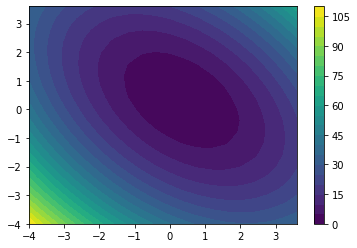

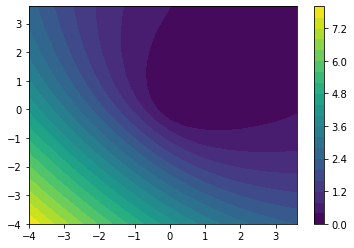

Erreur : train 0.094000, test 0.085000


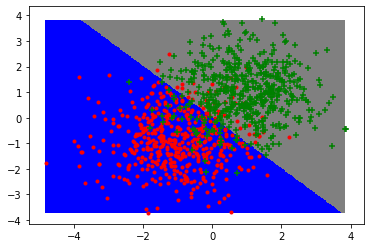

In [9]:
if __name__=="__main__":
    """ Tracer des isocourbes de l'erreur """
    plt.ion()
    trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
    testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
    plt.figure()
    plot_error(trainx,trainy,mse)
    plt.figure()
    plot_error(trainx,trainy,hinge)
    
    
    perceptron = Lineaire(hinge,hinge_g,max_iter=2000,eps=0.1,biais = False)
    perceptron.fit(trainx,trainy)
    
    print("Erreur : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)

## USPS data

In [2]:
from pathlib import Path

In [3]:
data_folder = Path("usps_data")

file_to_open = data_folder / "USPS_train.txt"

In [4]:
usps_data = load_usps(file_to_open)
labels = usps_data[1]
data = usps_data[0]

print("nb classes ->",len(np.unique(labels)))
print("nb data ->",len(data))

nb classes -> 10
nb data -> 7291


6


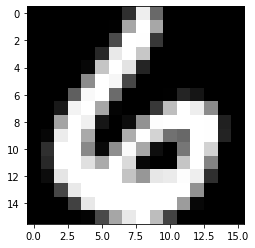

In [57]:
show_usps(data[0])
print(labels[0])

- Fonction to load data from 2 labels

In [58]:
from random import shuffle
def prepare_data(lab1,lab2):
    d = pd.DataFrame(data = labels, columns=["label"])
    index_lab1 = d[d["label"]==lab1].index
    index_lab2 = d[d["label"]==lab2].index
    ind = np.concatenate((index_lab1,index_lab2))

    train_indexes,test_indexes = [],[]

    #On sépare les indexes train/test (rapport 1/5 -> test)
    for i in range(len(ind)):
        if i%5 == 0:
            test_indexes.append(ind[i])
        else:
            train_indexes.append(ind[i])

    train_indexes = sorted(train_indexes, key=lambda k: random.random())

    #Données de train + labels
    trainx = np.array([data[i] for i in train_indexes])
    trainy = np.array([1 if labels[i] == lab1 else -1 for i in train_indexes]) #1 => label=6, -1 => label=9

    #Données de test + labels
    testx = np.array([data[i] for i in test_indexes])
    testy = np.array([1 if labels[i] == lab1 else -1 for i in test_indexes])
    
    return trainx, trainy, testx, testy

### Perceptron 6 vs 9

- load and visualize data

label -> 1


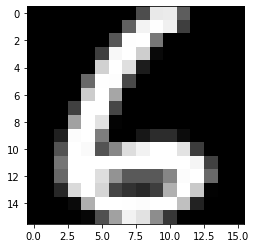

In [59]:
data69_train, data69_train_labels, data69_test, data69_test_labels = prepare_data(6,9)

i = 0
show_usps(data69_train[i])
print("label ->",data69_train_labels[i])

- Training + Score

In [60]:
perceptron69 = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.1)
perceptron69.fit(data69_train,data69_train_labels)
print("Erreur : train %f, test %f"% (perceptron69.score(data69_train,data69_train_labels),perceptron69.score(data69_test,data69_test_labels)))

Erreur : train 1.000000, test 0.980916


- Weights visualization

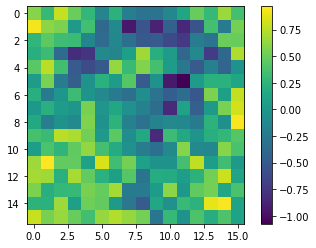

In [88]:
w = perceptron69.getWeights()
weights = w[0][0:256].reshape((16,16))
#print(weights.shape)
plt.imshow(weights)
plt.colorbar()
plt.show()

### Perceptron 8 vs 1

- Load and visualize data

label -> 1


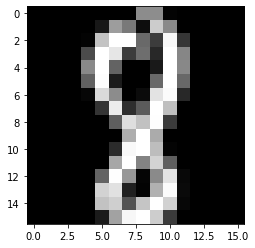

In [90]:
data81_train, data81_train_labels, data81_test, data81_test_labels = prepare_data(8,1)

i = 0
show_usps(data81_train[i])
print("label ->",data81_train_labels[i])

- Training + Score

In [91]:
perceptron81 = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.1)
perceptron81.fit(data81_train,data81_train_labels)
print("Erreur : train %f, test %f"% (perceptron81.score(data81_train,data81_train_labels),perceptron81.score(data81_test,data81_test_labels)))

Erreur : train 0.995958, test 0.987097


- Weights visualization

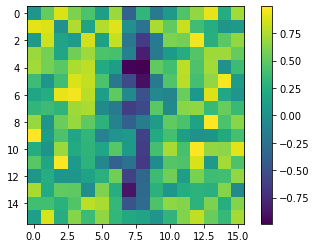

In [116]:
w = perceptron81.getWeights()
weights = w[0][0:256].reshape((16,16))
#print(weights)
plt.imshow(weights)
plt.colorbar()
plt.show()

## Perceptron all vs one

In [93]:
from random import shuffle
def prepare_data2(lab):

    train_indexes,test_indexes = [],[]

    #On sépare les indexes train/test (rapport 1/5 -> test)
    for i in range(len(labels)):
        if i%5 == 0:
            test_indexes.append(i)
        else:
            train_indexes.append(i)

    train_indexes = sorted(train_indexes, key=lambda k: random.random())

    #Données de train + labels
    trainx = np.array([data[i] for i in train_indexes])
    trainy = np.array([1 if labels[i] == lab else -1 for i in train_indexes]) #1 => label=lab, -1 => label!=lab

    #Données de test + labels
    testx = np.array([data[i] for i in test_indexes])
    testy = np.array([1 if labels[i] == lab else -1 for i in test_indexes])
    
    return trainx, trainy, testx, testy

In [94]:
data6_train, data6_train_labels, data6_test, data6_test_labels = prepare_data2(6)

label-> 28 1


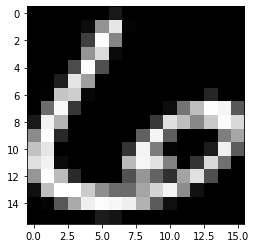

In [109]:
i=28
show_usps(data6_train[i])
print("label->",i, data6_train_labels[i])

In [111]:
perceptron6 = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.1)
perceptron6.fit(data6_train,data6_train_labels)
print("Erreur : train %f, test %f"% (perceptron6.score(data6_train,data6_train_labels),perceptron6.score(data6_test,data6_test_labels)))

Erreur : train 0.986283, test 0.981494


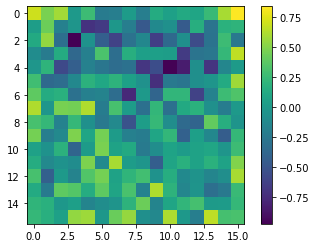

In [112]:
w = perceptron6.getWeights()
weights = w[0][0:256].reshape((16,16))
#print(weights.shape)
plt.imshow(weights)
plt.colorbar()
plt.show()